# Classify motor types by sound
## Why we do this?

In production environment like a warehouse distribution center, there are hundreds of AC motors that are driving conveyor belts and sorters day and night. Let’s say one motor at a critical link breaks down, it can cause major downtime of the whole system. An experienced maintenance engineer can identify a faulty motor by listening to its sounds and take action to correct it before it is too late. 

In this demo, we are going to train our model to be an expert. It can tell if a motor is faulty by listening to its sound.

I also have a [write up](https://www.dlology.com/blog/try-this-model-to-quickly-tell-if-it-is-a-faulty-motor-by-listening/) with more details.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
import librosa
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

#### Helper function to pickle and load stuff

In [2]:
import pickle
def __pickleStuff(filename, stuff):
    save_stuff = open(filename, "wb")
    pickle.dump(stuff, save_stuff)
    save_stuff.close()
def __loadStuff(filename):
    saved_stuff = open(filename,"rb")
    stuff = pickle.load(saved_stuff)
    saved_stuff.close()
    return stuff

# About the wav files

### Signal recording location
- de: motor drive end
- re: motor rear end

### Type of motors
- new: a new motor
- used: a used motor, still functional
- red: an identified bad motor

e.g. **used_60Hz_re_10s_22khz.wav** means, 
- an used motor
- VFD frequency is 60Hz
- microphone attached to the rear end of the motor housing
- recorded for 10 seconds
- the sampling rate is 22Khz

In [4]:
base_dir = "./data/"
sound_file_paths = ["new_60Hz_de_10s_22khz.wav","new_60Hz_re_10s_22khz.wav",
                    "used_60Hz_de_10s_22khz.wav","used_60Hz_re_10s_22khz.wav",
                    "red_60Hz_de_10s_22khz.wav","red_60Hz_re_10s_22khz.wav"]
# Output tags
sound_names = ["new","new",
               "used","used",
               "red","red"]



# Data preprocessing


## Function to normalize the dataset

In [3]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma


Our LSTM model expects fixed-length sequences as training data. We'll use a familiar method for generating these. Each generated sequence contains 100 training examples

In [5]:
N_TIME_STEPS = 100 # 22050 sr, --> 4.5ms
N_FEATURES = 1 # one channel audio signal
step = 50
segments = []
labels = []
for i, sound_file_path in enumerate(sound_file_paths):
    label = sound_names[i]
    sound_file_full_path = base_dir+sound_file_path
    sound_clip,sr = librosa.load(sound_file_full_path)
    print("Sampling rate for file \"{}\" is: {}Hz".format(sound_file_path,sr))
    v = feature_normalize(sound_clip)
    for i in range(0, len(v) - N_TIME_STEPS, step):
        segments.append([v[i: i + N_TIME_STEPS]])
        labels.append(label)

Sampling rate for file "new_60Hz_de_10s_22khz.wav" is: 22050Hz
Sampling rate for file "new_60Hz_re_10s_22khz.wav" is: 22050Hz
Sampling rate for file "used_60Hz_de_10s_22khz.wav" is: 22050Hz
Sampling rate for file "used_60Hz_re_10s_22khz.wav" is: 22050Hz
Sampling rate for file "red_60Hz_de_10s_22khz.wav" is: 22050Hz
Sampling rate for file "red_60Hz_re_10s_22khz.wav" is: 22050Hz


In [6]:
np.array(segments).shape

(26454, 1, 100)

Our training dataset has drastically reduced size after the transformation. Note that we take the most common activity and assign it as a label for the sequence. 

The shape of our tensor looks kinda strange. Let's transform it into sequences of 100 rows, each containing v. Let's apply a one-hot encoding to our labels, as well:

In [7]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [8]:
reshaped_segments.shape

(26454, 100, 1)

In [9]:
labels[0]

array([ 1.,  0.,  0.], dtype=float32)

Finally, let's split the data into training and test (20%) set:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [11]:
len(X_train)

21163

In [12]:
len(X_test)

5291

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [13]:
N_CLASSES = 3 # i.e. three types of motors (new, used, red)
N_HIDDEN_UNITS = 64

In [23]:
def lstm_cell(lstm_size, keep_prob):
    cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    return tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob = keep_prob)

def create_LSTM_model(inputs, keep_prob, num_layers=2):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])# [100, None, 1] transpose the 1st axis with the 2nd
    X = tf.reshape(X, [-1, N_FEATURES])# [None, 1]
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])# [None, 64]
    hidden = tf.split(hidden, N_TIME_STEPS, 0)# list of N_TIME_STEPS(100) tensors each shape [None, 64], split by the first axis
    # Stack 2 LSTM layers
    lstm_layers = tf.contrib.rnn.MultiRNNCell([lstm_cell(N_HIDDEN_UNITS, keep_prob) for _ in range(num_layers)])
    outputs, _ = tf.nn.static_rnn(cell = lstm_layers, inputs =hidden, dtype=tf.float32)  # list of 100 [None, 64] orginal static_rnn
    #outputs, _ = tf.contrib.rnn.static_rnn(cell = lstm_layers, inputs =hidden, dtype=tf.float32)  # orginal static_rnn

    # Get output for the last time step
    lstm_last_output = outputs[-1] #[None, 64]

    return tf.matmul(lstm_last_output, W['output']) + biases['output'] # [None, 3]

Now, let create placeholders for our model:

In [24]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [25]:
pred_Y = create_LSTM_model(X, keep_prob)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Again, we must properly name the tensor from which we will obtain predictions. We will use L2 regularization and that must be noted in our loss op:

In [26]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Finally, let's define optimizer and accuracy ops:

In [27]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32), name="accuracy")
# generated Summary for loss and accuracy show in tensorboard
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [28]:
N_EPOCHS = 30
BATCH_SIZE = 1024

In [29]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[])

sess=tf.InteractiveSession()
# Merge all the summaries and write them out
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter( './logs',sess.graph)
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end],
                                       keep_prob: 0.95})

    summary, _, acc_train, loss_train = sess.run([merged, pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train, keep_prob: 1})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    if i != 1 and i % 10 != 0:
        continue

    print('epoch: {} train accuracy: {} loss: {}'.format(i, acc_train, loss_train))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test, keep_prob: 1})

print()
print('final results: test accuracy: {} loss: {}'.format(acc_final, loss_final))

epoch: 1 train accuracy: 0.41941124200820923 loss: 1.6181986331939697
epoch: 10 train accuracy: 0.7905306220054626 loss: 0.8448232412338257
epoch: 20 train accuracy: 0.9354061484336853 loss: 0.5282873511314392
epoch: 30 train accuracy: 0.9843122959136963 loss: 0.35565468668937683

final results: test accuracy: 0.9839351177215576 loss: 0.3568215072154999


Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [30]:
pickle.dump(predictions, open("./data/predictions.p", "wb"))
pickle.dump(history, open("./data/history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './model/acoustic.pbtxt')  
saver.save(sess, save_path = "./model/acoustic.ckpt")
sess.close()

And loading it back:

In [32]:
history = pickle.load(open("./data/history.p", "rb"))
predictions = pickle.load(open("./data/predictions.p", "rb"))

# Evaluation

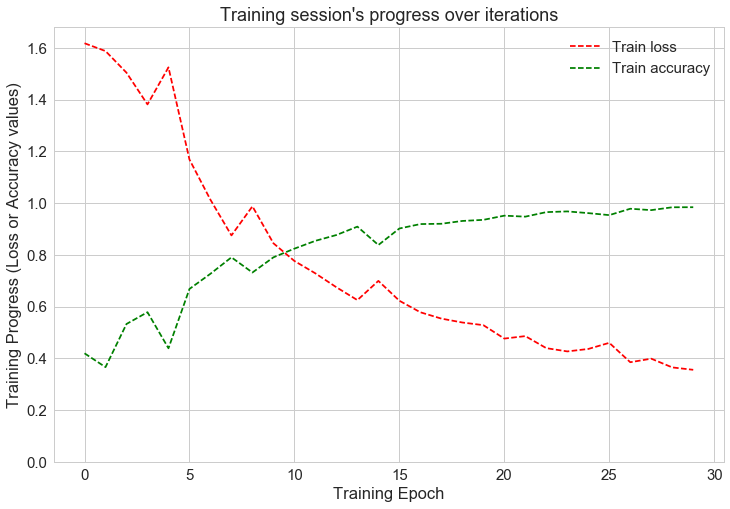

In [33]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [34]:
predictions.shape

(5291, 3)

In [35]:
LABELS = ["new","used","red"]

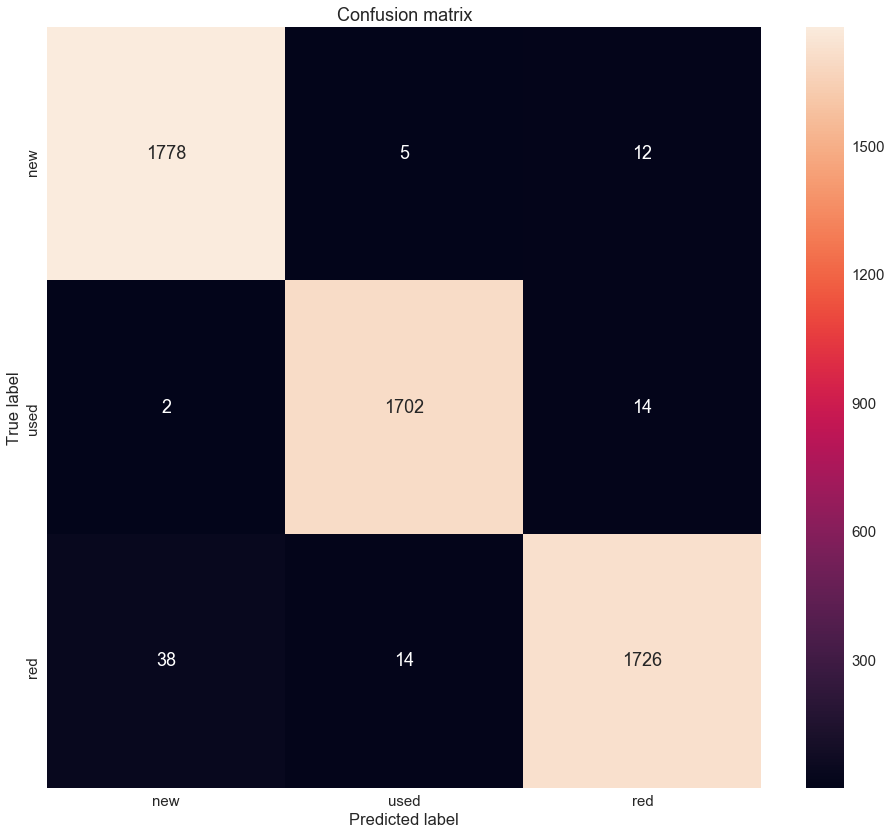

In [36]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

Again, it looks like our model performs real good.

# Exporting the model

In [37]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'acoustic'

input_graph_path = './model/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './model/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = './model/frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path, 
                          output_node_names="y_", restore_op_name=restore_op_name,
                          filename_tensor_name=filename_tensor_name, 
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./model/acoustic.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
5663 ops in the final graph.


# Predict with the model
## Helper function to load the exported graph

In [38]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

In [39]:
graph = load_graph('./model/frozen_acoustic.pb')

### Take a look at what tensors are available

In [40]:
for op in graph.get_operations():
    print(op.name)

prefix/input
prefix/keep_prob
prefix/Variable
prefix/Variable/read
prefix/Variable_1
prefix/Variable_1/read
prefix/Variable_2
prefix/Variable_2/read
prefix/Variable_3
prefix/Variable_3/read
prefix/transpose/perm
prefix/transpose
prefix/Reshape/shape
prefix/Reshape
prefix/MatMul
prefix/add
prefix/Relu
prefix/split/split_dim
prefix/split
prefix/rnn/Shape
prefix/rnn/strided_slice/stack
prefix/rnn/strided_slice/stack_1
prefix/rnn/strided_slice/stack_2
prefix/rnn/strided_slice
prefix/rnn/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/ExpandDims/dim
prefix/rnn/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/ExpandDims
prefix/rnn/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/Const
prefix/rnn/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/concat/axis
prefix/rnn/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/concat
prefix/rnn/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZe

prefix/rnn/rnn/multi_rnn_cell/cell_1_27/dropout/Floor
prefix/rnn/rnn/multi_rnn_cell/cell_1_27/dropout/div
prefix/rnn/rnn/multi_rnn_cell/cell_1_27/dropout/mul
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/basic_lstm_cell_27/concat/axis
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/basic_lstm_cell_27/concat
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/basic_lstm_cell_27/MatMul
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/basic_lstm_cell_27/BiasAdd
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/split_27/split_dim
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/split_27
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/add_54/y
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/add_54
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/Sigmoid_81
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/mul_81
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_lstm_cell/Sigmoid_82

prefix/rnn/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/add_145
prefix/rnn/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/Tanh_145
prefix/rnn/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/Sigmoid_218
prefix/rnn/rnn/multi_rnn_cell/cell_0/cell_0/basic_lstm_cell/mul_218
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/Shape
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/random_uniform/min
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/random_uniform/max
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/random_uniform/RandomUniform
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/random_uniform/sub
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/random_uniform/mul
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/random_uniform
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/add
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/Floor
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/div
prefix/rnn/rnn/multi_rnn_cell/cell_1_72/dropout/mul
prefix/rnn/rnn/multi_rnn_cell/cell_1/cell_1/basic_l

In [42]:
# We access the input and output nodes 
x = graph.get_tensor_by_name('prefix/input:0')
keep_prob = graph.get_tensor_by_name('prefix/keep_prob:0')
y = graph.get_tensor_by_name('prefix/y_:0')

In [43]:
# We launch a Session
with tf.Session(graph=graph) as sess:
    # Note: we don't nee to initialize/restore anything
    # There is no Variables in this graph, only hardcoded constants 
    y_out = sess.run(y, feed_dict={x: X_test[10:15], keep_prob: 1})
    print(y_out)

[[  1.54450675e-03   9.96833980e-01   1.62158709e-03]
 [  3.99442215e-04   9.99169111e-01   4.31466498e-04]
 [  7.99518358e-03   1.08194314e-02   9.81185377e-01]
 [  9.99725759e-01   8.83990106e-06   2.65350129e-04]
 [  2.88181435e-02   6.07909961e-03   9.65102792e-01]]


In [44]:
np.argmax(y_out,1)

array([1, 1, 2, 0, 2], dtype=int64)

In [45]:
np.argmax(y_test[10:15],1)

array([1, 1, 2, 0, 2], dtype=int64)

## Predict motor type with new wav file
**test_new_60Hz.wav** is another recording from a new motor.

In [73]:

'''
Segmentment the wav file and return the model input data
'''
def process_wav(filepath):
    N_TIME_STEPS = 100 # 22050 sr, --> 4.5ms
    N_FEATURES = 1 # one channel audio signal
    step = 50
    segments = []
    sound_clip,sr = librosa.load(filepath)
    print("Sampling rate for file \"{}\" is: {}Hz".format(sound_file_path,sr))
    v = feature_normalize(sound_clip)
    for i in range(0, len(v) - N_TIME_STEPS, step):
        segments.append([v[i: i + N_TIME_STEPS]])
    model_input_data = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    return model_input_data

sound_file_path = "test_new_60Hz.wav"
sound_file_full_path = base_dir+sound_file_path

def predict_recording(filepath):
    X_predict = process_wav(filepath)
    # We launch a Session
    with tf.Session(graph=graph) as sess:
        # Note: we don't nee to initialize/restore anything
        # There is no Variables in this graph, only hardcoded constants 
        y_predicts = sess.run(y, feed_dict={x: X_predict, keep_prob: 1})        
        LABELS = ["new","used","red"]
        predicted_logit = stats.mode(np.argmax(y_predicts,1))[0][0]
        predicted_label = LABELS[predicted_logit]
        predicted_probability = stats.mode(np.argmax(y_predicts,1))[1][0] / len(y_predicts)
        return (predicted_label, predicted_probability)


In [74]:
predicted, prob = predict_recording(sound_file_full_path)
print("Recording \"{}\" is predicted to be a \"{}\" motor with probability {}".format(sound_file_full_path, predicted, prob))

Sampling rate for file "test_new_60Hz.wav" is: 22050Hz
Recording "./data/test_new_60Hz.wav" is predicted to be a "new" motor with probability 0.8227010881160657
